# Why this kernel?
Why should you read through this kernel? The goal is to have a visual guide on which strategy leads to the win:

- the data will be read and **memory footprint will be reduced**;
- **missing data** will be checked;
- **aggregations of the data over teams are performed**;
- a baseline model **on team level** will be trained:
   - Gradient boosting model as implemented in **LightGBM** is used;
   - **Mean absolute error (MAE) is used as the loss function** in the training (consistently with the final evaluation metric). **FAIR loss**  was also tried and seems to lead similar results
   - Training is performed with **early stopping based on MAE metric**.
 - The training is implemented in a cross validation (CV) loop and **out-of-fold (OOF) predictions are stored** for future use in stacking.
 - **Test predictions** are obtained as an **average over predictions from models trained on k-1 fold subsets**.
- Predictions are **clipped to `[0,1]` range**

# Side note: score of 0.0411 can be achieved with only 100k games from the train set with ranking post-processing

In [68]:
# The number of MATCHES to use in training. Whole training dataset is used anyway. Use it to have fast turn-around. Set to 50k for all entries
max_matches_trn=10000
# The number of entries from test to read in. Use it to have fast turn-around. Set to None for all entries
max_events_tst=1000
# Number on CV folds
n_cv=3

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import mean_squared_error, mean_absolute_error

PATH='/home/mlisovyi/.kaggle/competitions/pubg-finish-placement-prediction/'
# PATH='../input'

import os
print(os.listdir(PATH))

['sample_submission.csv.zip', 'train.csv', 'sample_submission.csv', 'test.csv', 'train.csv.zip', 'test.csv.zip']


Define a function to reduce memory foorprint

In [70]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Read in the data

In [71]:
df_trn = pd.read_csv(PATH+'/train.csv', nrows=None)
df_trn = reduce_mem_usage(df_trn)

df_tst = pd.read_csv(PATH+'/test.csv',  nrows=max_events_tst)
df_tst = reduce_mem_usage(df_tst)

Memory usage of dataframe is 864.34 MB
Memory usage after optimization is: 178.69 MB
Decreased by 79.3%
Memory usage of dataframe is 0.19 MB
Memory usage after optimization is: 0.04 MB
Decreased by 79.5%


In [72]:
df_trn = df_trn.query('matchId < @max_matches_trn')

In [73]:
print('Number of training entries after selecting a subset of matches: {}'.format(df_trn.shape[0]))

Number of training entries after selecting a subset of matches: 913828


In [74]:
# we will NOT use in training
features_not2use = ['Id', 'groupId', 'matchId', 'numGroups']

## How do the data look like?

In [75]:
df_trn.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.25000,2,0,4,17,1050,2,1,65.312500,29,28,1,591.5,0,0.0,0,0,782.500000,4,1458,0.856934
1,1,440875,1,1,0,37.65625,1,1,0,45,1072,1,1,13.546875,26,23,0,0.0,0,0.0,0,0,119.625000,3,1511,0.040009
2,2,878242,2,0,1,93.75000,1,0,2,54,1404,0,0,0.000000,28,28,1,0.0,0,0.0,0,0,3248.000000,5,1583,0.740723
3,3,1319841,3,0,0,95.87500,0,0,0,86,1069,0,0,0.000000,97,94,0,0.0,0,0.0,0,0,21.484375,1,1489,0.114624
4,4,1757883,4,0,1,0.00000,0,0,1,58,1034,0,0,0.000000,47,41,0,0.0,0,0.0,0,0,641.000000,4,1475,0.521484


In [76]:
df_trn.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913828 entries, 0 to 4356062
Columns: 26 entries, Id to winPlacePerc
dtypes: float16(6), int16(2), int32(3), int8(15)
memory usage: 44.4 MB


In [77]:
df_tst.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 25 entries, Id to winPoints
dtypes: float16(5), int16(2), int32(3), int8(15)
memory usage: 40.1 KB


In [127]:
x = df_trn.groupby('matchId').agg({'maxPlace':['median','std'],
                               'numGroups':['median','std']
                              })

In [130]:
x.columns = pd.Index([e[0] + "_" + e[1].upper() for e in x.columns])    

In [135]:
(x['numGroups_MEDIAN'] != x['maxPlace_MEDIAN']).sum()

7121

In [137]:
x.iloc[:,[0,2]]

,numGroups_MEDIAN,maxPlace_MEDIAN
matchId,,
0,28,29
1,23,26
2,28,28
3,94,97
4,41,47
5,96,96
6,40,44
7,46,46
8,28,28


In [189]:
x.query('maxPlace_MEDIAN > 30 and maxPlace_MEDIAN<40')

,numGroups_MEDIAN,numGroups_STD,maxPlace_MEDIAN,maxPlace_STD
matchId,,,,
31,35,0.0,35,0.0
86,28,0.0,31,0.0
130,29,0.0,31,0.0
202,30,0.0,31,0.0
208,30,0.0,31,0.0
218,31,0.0,31,0.0
303,32,0.0,32,0.0
306,31,0.0,31,0.0
311,35,0.0,35,0.0


In [190]:
x1 = df_trn.query('matchId == 3121')
x2 = x1[['groupId','matchId','winPlacePerc']].sort_values(by='winPlacePerc').drop_duplicates()
#x2 = x2.diff()
x2['i'] = range(x2.shape[0])
x2

,groupId,matchId,winPlacePerc,i
1238479,931389,3121,0.000000,0
2456843,931388,3121,0.026306,1
3335707,931387,3121,0.052612,2
1379958,931386,3121,0.078979,3
432688,931385,3121,0.105286,4
1990482,931384,3121,0.131592,5
2363681,931383,3121,0.157959,6
1427085,931382,3121,0.184204,7
2083869,931381,3121,0.210449,8
2689512,931380,3121,0.236816,9


In [177]:
for i in range(6):
    x1 = df_trn.query('matchId == @i')
    x2 = x1[['groupId','matchId','winPlacePerc']].sort_values(by='winPlacePerc').drop_duplicates()
    x2['i'] = range(x2.shape[0])
    print(x2.shape)
    display(x2)

(28, 4)


,groupId,matchId,winPlacePerc,i
1612337,21,0,0.000000,0
4012997,20,0,0.035706,1
3848527,19,0,0.071411,2
857219,18,0,0.107117,3
1188203,17,0,0.142944,4
3806881,16,0,0.178589,5
2314030,15,0,0.214355,6
1893971,14,0,0.250000,7
4092783,13,0,0.285645,8
667547,12,0,0.321289,9


(23, 4)


,groupId,matchId,winPlacePerc,i
3681199,440876,1,0.000000,0
1,440875,1,0.040009,1
190934,440874,1,0.080017,2
2314031,440873,1,0.119995,3
2779434,440872,1,0.160034,4
47735,440871,1,0.199951,5
1987427,440870,1,0.239990,6
3596516,440868,1,0.280029,7
4131561,440867,1,0.320068,8
1235397,440866,1,0.360107,9


(28, 4)


,groupId,matchId,winPlacePerc,i
3765104,878236,2,0.000000,0
2500354,878235,2,0.036987,1
1565276,878234,2,0.074097,2
1471113,878233,2,0.111084,3
715018,878232,2,0.148071,4
2080816,878231,2,0.185181,5
1329735,878230,2,0.222168,6
286398,878229,2,0.259277,7
904576,878228,2,0.296387,8
524902,878226,2,0.333252,9


(94, 4)


,groupId,matchId,winPlacePerc,i
3553667,1319853,3,0.000000,0
2593440,1319852,3,0.010399,1
1987429,1319851,3,0.020798,2
1800304,1319850,3,0.031204,3
2034128,1319849,3,0.041687,4
1093762,1319848,3,0.052094,5
238668,1319847,3,0.062500,6
2732964,1319846,3,0.072876,7
2314033,1319844,3,0.083313,8
4053205,1319843,3,0.093811,9


(41, 4)


,groupId,matchId,winPlacePerc,i
904578,1757905,4,0.000000,0
4053206,1757904,4,0.021698,1
857223,1757903,4,0.043488,2
2593441,1757902,4,0.065186,3
3639008,1757901,4,0.086975,4
3681202,1757900,4,0.108704,5
1093763,1757899,4,0.130371,6
3890022,1757898,4,0.152222,7
715020,1757896,4,0.195679,8
3806885,1757895,4,0.217407,9


(96, 4)


,groupId,matchId,winPlacePerc,i
334131,2200853,5,0.000000,0
4053207,2200852,5,0.010498,1
286401,2200851,5,0.020996,2
4092788,2200850,5,0.031586,3
1987431,2200849,5,0.042114,4
4239604,2200848,5,0.052612,5
3057737,2200847,5,0.063171,6
3510402,2200845,5,0.073730,7
4205393,2200844,5,0.084229,8
3639009,2200843,5,0.094727,9


In [ ]:
x2 = x1[['groupId','matchId','winPlacePerc']].sort_values(by='winPlacePerc').drop_duplicates()
x2['i'] = range(x2.shape[0])
x2

In [161]:
x2

,groupId,matchId,winPlacePerc
3681199,NaN,NaN,NaN
1,-1.0,0.0,0.040009
190934,-1.0,0.0,0.040009
2314031,-1.0,0.0,0.039978
2779434,-1.0,0.0,0.040039
47735,-1.0,0.0,0.039917
1987427,-1.0,0.0,0.040039
3596516,-2.0,0.0,0.040039
4131561,-1.0,0.0,0.040039
1235397,-1.0,0.0,0.040039


In [155]:
28*(1 - x2['winPlacePerc'])

3765104    28.000000
2500354    26.968750
1565276    25.921875
1471113    24.875000
715018     23.859375
2080816    22.812500
1329735    21.781250
286398     20.734375
904576     19.703125
524902     18.671875
3287444    17.640625
2453797    16.593750
3510399    15.562500
4169186    14.515625
477271     13.484375
1893973    12.437500
2732963    11.406250
1800303    10.375000
334128      9.335938
143202      8.296875
2           7.257812
2639964     6.218750
2034127     5.179688
4092785     4.140625
3241860     3.117188
2314032     2.078125
2174152     1.039062
3890020     0.000000
Name: winPlacePerc, dtype: float16

In [141]:
1./0.035706

28.00649750742172

- The training dataset has 4.3M entries, which is not small and aloows for advanced models like GBM and NN to dominate.
- The test dataset is only 1.9M entries
- There are 25 features (+ the target in the train dataset)

## Are there missing data?

In [78]:
df_trn.isnull().sum().sum()

0

Good news: **There are no entries with `np.nan`**, so at the first glance we do not need to do anything fancy about missing data. 

There might be some default values pre-filled into missing entries- this would have to be discovered.

# Feature engineering: group by teams

In [79]:
def fe(df_):
    feats_add = [('rsDistance', 'rideDistance', 'swimDistance'),
                 ('totalDistance', 'fe_rsDistance_ADD', 'walkDistance'),
                 ('totalPoints', 'killPoints', 'winPoints'),
                 #('', '', '')
                ]
    feats_div = [
                 ('headshotFraction', 'headshotKills', 'kills'),
                 ('weaponsPerMeter', 'weaponsAcquired', 'fe_totalDistance_ADD'),
                 ('kill2win', 'killPoints', 'winPoints'),
                 ('damage2kills', 'damageDealt', 'kills')
                ]

    for f_new, f1, f2 in feats_add:
        df_['fe_' + f_new + '_ADD'] = df_[f1] + df_[f2]
    for f_new, f1, f2 in feats_div:
        df_['fe_' + f_new + '_DIV'] = df_[f1] / df_[f2]
        
    return df_
        
df_trn = fe(df_trn)
df_tst = fe(df_tst)

In [80]:
agg_team = {c: ['mean', 'min', 'max', 'median', 'sum', 'std'] 
            for c in [c 
                      for c in df_trn.columns 
                      if c not in features_not2use 
                      and c != 'winPlacePerc']
           }
agg_team['numGroups'] = ['size','median']

print(agg_team.keys())

def preprocess(df):    
    df_gb = df.groupby('groupId').agg(agg_team)
    df_gb.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_gb.columns])    
    return df_gb

df_trn_gb = preprocess(df_trn)
df_tst_gb = preprocess(df_tst)

y = df_trn.groupby('groupId')['winPlacePerc'].median()
# target for the ranker
y_rnk = df_trn.groupby(['matchId', 'groupId'])['winPlacePerc'].median().groupby('matchId').rank().astype(np.int16)
y_rnk.index = y_rnk.index.droplevel(0)

dict_keys(['rideDistance', 'fe_totalPoints_ADD', 'fe_rsDistance_ADD', 'assists', 'fe_headshotFraction_DIV', 'DBNOs', 'fe_weaponsPerMeter_DIV', 'fe_totalDistance_ADD', 'vehicleDestroys', 'teamKills', 'damageDealt', 'numGroups', 'killStreaks', 'swimDistance', 'winPoints', 'killPlace', 'revives', 'heals', 'longestKill', 'fe_kill2win_DIV', 'kills', 'roadKills', 'weaponsAcquired', 'fe_damage2kills_DIV', 'walkDistance', 'boosts', 'headshotKills', 'killPoints', 'maxPlace'])


# Prepare the data

In [81]:
w_trn = df_trn_gb['numGroups_SIZE']
w_tst = df_tst_gb['numGroups_SIZE']

In [82]:
g_trn = df_trn_gb.iloc[:,:0].merge(df_trn[['matchId','groupId']].drop_duplicates().set_index('groupId'), 
                                   how='left', left_index=True, right_index=True)['matchId']
g_tst = df_tst_gb.iloc[:,:0].merge(df_tst[['matchId','groupId']].drop_duplicates().set_index('groupId'), 
                                   how='left', left_index=True, right_index=True)['matchId']

# Train and evaluate a model
Start by defining handy helper functions...

In [125]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb


def learning_rate_decay_power(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    base_learning_rate = 0.20
    min_lr = 5e-2
    lr = base_learning_rate  * np.power(.996, current_iter)
    return lr if lr > min_lr else min_lr


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = KFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                #fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        print(y_true_tmp.head(10))
        print(y_pred_tmp.head(10))
        scores.append(metric(y_true_tmp, y_pred_tmp, **metric_args))
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(perf_eval['score_i']))

In [122]:
mdl_inputs = {
        'lgbm1_rnk': (lgb.LGBMRanker(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', 
                                     n_jobs=4, n_estimators=1000, learning_rate=0.05,
                                     label_gain=np.logspace(0,100, num=101, base=2)-1
                                    ),
                 {'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 30, 'reg_alpha': 1},#, 'subsample': 0.75}, 
                 {"early_stopping_rounds":100, 
                  "eval_metric" : 'ndcg',
                  'eval_at':1,
                  'eval_names': ['train', 'early_stop'],
                  'verbose': False, 
                  #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 y_rnk,
                 g_trn
                ),
       }

In [126]:
%%time
mdls = {}
results = {}
y_oofs = {}
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    print('--------------- {} -----------'.format(name))
    mdl_, perf_eval_, y_oof_ = train_model_in_CV(mdl, df_trn_gb, y_, mean_absolute_error, 
                                                          metric_args={'index_weight': w_trn},
                                                          model_name=name, 
                                                          opt_parameters_=mdl_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=500, 
                                                          groups=g_, y_eval=y)
    results[name] = perf_eval_
    mdls[name] = mdl_
    y_oofs[name] = y_oof_
    print_perf_clf(name, perf_eval_)

--------------- lgbm1_rnk -----------
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	train's ndcg@1: 0.215736	early_stop's ndcg@1: 0.0741852
groupId
1219    1.000000
1220    0.804199
1221    0.782715
1222    0.760742
1223    0.739258
1224    0.717285
1225    0.695801
1226    0.673828
1227    0.652344
1228    0.630371
Name: winPlacePerc, dtype: float16
groupId
1219   -0.073760
1220   -0.129513
1221   -0.178704
1222   -0.118764
1223   -0.080789
1224   -0.142379
1225   -0.051813
1226   -0.245439
1227   -0.149607
1228   -0.069076
dtype: float64
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	train's ndcg@1: 0.216882	early_stop's ndcg@1: 0.0744086
groupId
437    1.000000
438    0.909180
439    0.000000
440    0.898926
441    0.888672
442    0.878906
443    0.868652
444    0.848633
445    0.838379
446    0.828125
Name: winPlacePerc, dtype: float16
groupId
437   -0.281736
438   -0.34

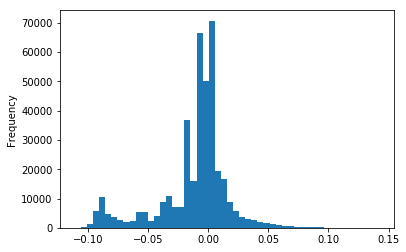

In [124]:
y_oofs['lgbm1_rnk'].plot('hist',bins=50)

In [112]:
x = y_oofs['lgbm1_rnk']

In [113]:
g_trn.shape

(393412,)

In [114]:
x.shape

(393412,)

In [115]:
pd.concat([x,g_trn],axis=1).groupby('matchId')[0].rank(pct=True)

groupId
1          0.464286
2          0.964286
3          0.678571
4          0.821429
5          0.642857
6          0.607143
7          0.428571
8          0.785714
9          1.000000
10         0.857143
11         0.285714
12         0.535714
13         0.750000
14         0.178571
15         0.071429
16         0.250000
17         0.142857
18         0.357143
19         0.107143
20         0.035714
21         0.392857
22         0.571429
23         0.321429
24         0.714286
25         0.500000
26         0.892857
27         0.928571
28         0.214286
437        0.901099
438        0.692308
439        0.956044
440        0.681319
441        0.747253
442        0.879121
443        0.604396
444        0.824176
445        0.637363
446        0.813187
447        0.703297
448        0.725275
449        1.000000
450        0.890110
451        0.780220
452        0.714286
453        0.615385
454        0.758242
455        0.571429
456        0.989011
457        0.527473
458        0

In [116]:
pd.concat([x,g_trn],axis=1)

,0,matchId
groupId,,
1,-0.208349,0
2,-0.079826,0
3,-0.154015,0
4,-0.107980,0
5,-0.163209,0
6,-0.168782,0
7,-0.221800,0
8,-0.139285,0
9,-0.072965,0


In [117]:
mean_absolute_error(df_trn.groupby('groupId')['winPlacePerc'].median(), 
                    pd.concat([x,g_trn],axis=1).groupby('matchId')[0].rank(pct=True)
                   )

0.21175272386827246

In [106]:
df_trn.groupby('groupId')['winPlacePerc'].median()

groupId
1          1.000000
2          0.678711
3          0.643066
4          0.606934
5          0.571289
6          0.535645
7          0.464355
8          0.428711
9          0.392822
10         0.357178
11         0.964355
12         0.321289
13         0.285645
14         0.250000
15         0.214355
16         0.178589
17         0.142944
18         0.107117
19         0.071411
20         0.035706
21         0.000000
22         0.928711
23         0.893066
24         0.856934
25         0.821289
26         0.785645
27         0.750000
28         0.714355
437        1.000000
438        0.909180
439        0.000000
440        0.898926
441        0.888672
442        0.878906
443        0.868652
444        0.848633
445        0.838379
446        0.828125
447        0.818359
448        0.989746
449        0.808105
450        0.797852
451        0.788086
452        0.737305
453        0.727539
454        0.979980
455        0.707031
456        0.696777
457        0.666504
458        0

In [108]:
g_trn

groupId
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
437        1000
438        1000
439        1000
440        1000
441        1000
442        1000
443        1000
444        1000
445        1000
446        1000
447        1000
448        1000
449        1000
450        1000
451        1000
452        1000
453        1000
454        1000
455        1000
456        1000
457        1000
458        1000
459        1000
460        1000
461        1000
462        1000
463        1000
464        1000
465        1000
466        1000
467        1000
468        1000
469        1000
470        1000


Now let's define the parameter and model in a scalable fashion (we can add later on further models to the list and it will work out-of-the-box). 

The format is a dictionary with keys that are user model names and items being an array (or tuple) of:

- model to be fitted;
- additional model parameters to be set;
- model fit parameters (they are passed to `model.fit()` call);
- target variable.

In [41]:
mdl_inputs = {
        # This will be with MAE loss
        'lgbm1_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', 
                                        n_jobs=4, n_estimators=1000, learning_rate=0.1),
                 {'objective': 'mse', 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 30, 'reg_alpha': 1, 'subsample': 0.75}, 
                 {"early_stopping_rounds":100, 
                  "eval_metric" : 'mae',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': False, 
                  #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 y,
                 None
                ),
#         'lgbm1_rnk': (lgb.LGBMRanker(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', 
#                                      n_jobs=4, n_estimators=5000, learning_rate=0.1,
#                                      label_gain=np.logspace(0,100, num=101, base=2)-1
#                                     ),
#                  {'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 30, 'reg_alpha': 1, 'subsample': 0.75}, 
#                  {"early_stopping_rounds":100, 
#                   "eval_metric" : 'ndcg',
#                   'eval_names': ['train', 'early_stop'],
#                   'verbose': False, 
#                   #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
#                   'categorical_feature': 'auto'},
#                  y_rnk
#                 ),
       }

Do the actual model training

In [42]:
%%time
mdls = {}
results = {}
y_oofs = {}
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    print('--------------- {} -----------'.format(name))
    mdl_, perf_eval_, y_oof_ = train_model_in_CV(mdl, df_trn_gb, y_, mean_absolute_error, 
                                                          metric_args={'index_weight': w_trn},
                                                          model_name=name, 
                                                          opt_parameters_=mdl_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=500, 
                                                          groups=g_)
    results[name] = perf_eval_
    mdls[name] = mdl_
    y_oofs[name] = y_oof_
    print_perf_clf(name, perf_eval_)

--------------- lgbm1_reg -----------
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0434286	early_stop's l1: 0.0485762
Early stopping, best iteration is:
[821]	train's l1: 0.0408757	early_stop's l1: 0.0484817
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0432264	early_stop's l1: 0.0490624
Early stopping, best iteration is:
[815]	train's l1: 0.0407107	early_stop's l1: 0.0489536
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0434926	early_stop's l1: 0.0484175
Early stopping, best iteration is:
[890]	train's l1: 0.0404192	early_stop's l1: 0.0483015
Performance of the model:
Mean(Val) score inner lgbm1_reg Classifier: 0.0486+-0.0003
Min/max scores on folds: 0.0483 / 0.0489
OOF score inner lgbm1_reg Classifier: 0.0486
Scores in individual folds: [0.048481698428896366, 0.04894881309508835, 0.048301479056866554]
--------------- lgbm2_reg -----------
Training until validation scores do

In [40]:
%%time
mdl_inputs = {
        # This will be with MAE loss
        'lgbm1_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', 
                                        n_jobs=-1, n_estimators=1000, learning_rate=0.1),
                 {'objective': 'fair', 'colsample_bytree': 0.5, 'min_child_weight': 10.0, 'num_leaves': 60, 'reg_alpha': 1},#, 'subsample': 0.75}, 
                 {"early_stopping_rounds":100, 
                  "eval_metric" : 'mae',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': False, 
                  #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 y,
                 None
                ),
}
mdls = {}
results = {}
y_oofs = {}
for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    print('--------------- {} -----------'.format(name))
    mdl_, perf_eval_, y_oof_ = train_model_in_CV(mdl, df_trn_gb, y_, mean_absolute_error, 
                                                          metric_args={'index_weight': w_trn},
                                                          model_name=name, 
                                                          opt_parameters_=mdl_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=500, 
                                                          groups=g_)
    results[name] = perf_eval_
    mdls[name] = mdl_
    y_oofs[name] = y_oof_
    print_perf_clf(name, perf_eval_)

--------------- lgbm1_reg -----------
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0394895	early_stop's l1: 0.048614
Early stopping, best iteration is:
[490]	train's l1: 0.0396229	early_stop's l1: 0.0486102
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0395089	early_stop's l1: 0.0491274
Early stopping, best iteration is:
[528]	train's l1: 0.0391545	early_stop's l1: 0.0491113
Training until validation scores don't improve for 100 rounds.
[500]	train's l1: 0.0396736	early_stop's l1: 0.0484234
Early stopping, best iteration is:
[465]	train's l1: 0.0401561	early_stop's l1: 0.0484034
Performance of the model:
Mean(Val) score inner lgbm1_reg Classifier: 0.0487+-0.0003
Min/max scores on folds: 0.0484 / 0.0491
OOF score inner lgbm1_reg Classifier: 0.0487
Scores in individual folds: [0.04861014804977451, 0.04911134685222618, 0.04840342340510084]
CPU times: user 19min 10s, sys: 19.5 s, total: 19min 29s
Wall time: 2min 57s

Let's plot how predictions look like

Text(0.5,0,'Predicted winPlacePerc OOF')

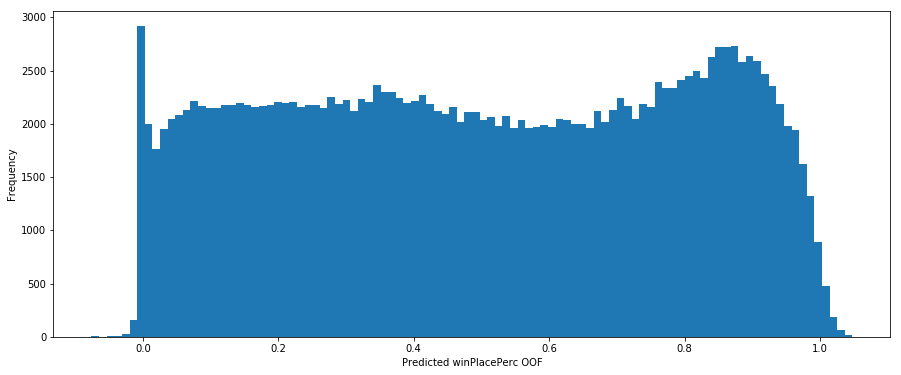

In [25]:
k = list(y_oofs.keys())[0]
_ = y_oofs[k].plot('hist', bins=100, figsize=(15,6))
plt.xlabel('Predicted winPlacePerc OOF')

Note, that predictions are spilled outside of the `[0,1]` range, which is not meaningful for percentage value. **We will clip test predictions to be within the meaningful range.** This will improve the score slightly

## Visualise importance of features

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_importances(feature_importance_df_, n_feat=30, silent=False, dump_strs=[], 
                        fout_name=None, title='Features (avg over folds)'):
    '''
    Make a plot of most important features from a tree-based model

    Parameters
    ----------
    feature_importance_df_ : pd.DataFrame
        The input dataframe. 
        Must contain columns `'feature'` and `'importance'`.
        The dataframe will be first grouped by `'feature'` and the mean `'importance'` will be calculated.
        This allows to calculate and plot importance averaged over folds, 
        when the same features appear in the dataframe as many time as there are folds in CV.
    n_feats : int [default: 20]
        The maximum number of the top features to be plotted
    silent : bool [default: False]
        Dump additionsl information, in particular the mean importances for features 
        defined by `dump_strs` and the features with zero (<1e-3) importance
    dump_strs : list of strings [default: []]
        Features containing either of these srings will be printed to the screen
    fout_name : str or None [default: None]
        The name of the file to dump the figure. 
        If `None`, no file is created (to be used in notebooks)
    '''
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index  
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    
    if not silent:
        print('The list of features with 0 importance: ')
        print(df_2_neglect.index.values.tolist())

        pd.set_option('display.max_rows', 500)
        pd.set_option('display.max_columns', 500)
        for feat_prefix in dump_strs:
            feat_names = [x for x in mean_imp.index if feat_prefix in x]
            print(mean_imp.loc[feat_names].sort_values(by='importance', ascending=False))
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(title)
    plt.tight_layout()

    if fout_name is not None:
        plt.savefig(fout_name)


The list of features with 0 importance: 
['maxPlace_STD', 'roadKills_MEDIAN', 'roadKills_MIN', 'teamKills_MEDIAN', 'teamKills_MIN', 'vehicleDestroys_MIN', 'vehicleDestroys_SUM']


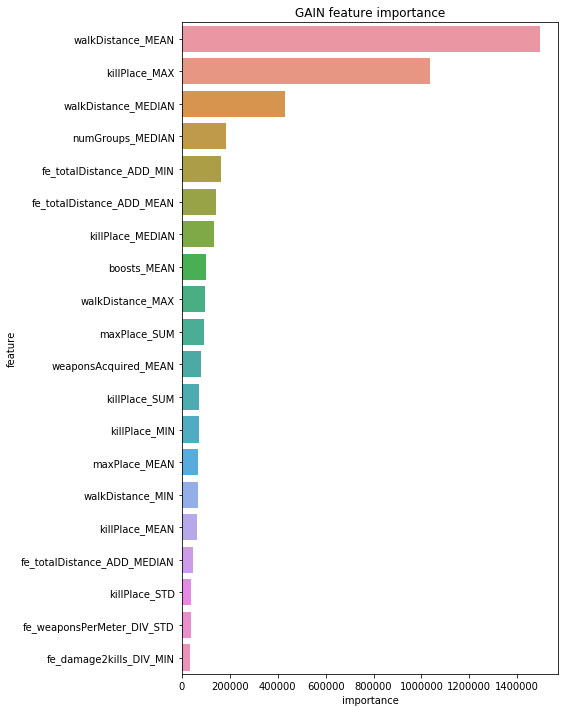

In [27]:
display_importances(pd.DataFrame({'feature': df_trn_gb.columns,
                                  'importance': mdls['lgbm1_reg'][0][1].booster_.feature_importance('gain')}),
                    n_feat=20,
                    title='GAIN feature importance',
                    fout_name='feature_importance_gain.png'
                   )

## Prepare submission

In [28]:
%%time
y_subs= {}
for c in mdl_inputs:
    mdls_= mdls[c]
    y_sub = np.zeros(df_tst_gb.shape[0])
    for mdl_ in mdls_:
        y_sub += np.clip(mdl_[1].predict(df_tst_gb), 0, 1)
    y_sub /= n_cv
    
    y_subs[c] = y_sub

CPU times: user 1.21 s, sys: 11.9 ms, total: 1.23 s
Wall time: 332 ms


In [29]:
df_sub = pd.read_csv('../input/sample_submission.csv', nrows=max_events_tst)

FileNotFoundError: File b'../input/sample_submission.csv' does not exist

In [ ]:

for c in mdl_inputs:
    #Submission predictions
    y_tmp = pd.Series(y_subs[c], index=df_tst_gb.index)
    df_sub['winPlacePerc'] = df_tst.iloc[:,:5].merge(y_tmp.to_frame(), right_index=True, left_on='groupId', how='left')[0]
    df_sub.to_csv('sub_{}.csv'.format(c), index=False)
    #submission predictions ranked within each game
    y_sub_ranked = y_tmp.to_frame().merge(df_tst[['groupId', 'matchId']].drop_duplicates(), 
                           left_index=True, 
                           right_on='groupId', 
                           how='left').set_index(['matchId','groupId']).groupby(['matchId']).rank(pct=True)
    df_sub['winPlacePerc'] = df_tst[['groupId', 'matchId']].merge(y_sub_ranked, how='left', on=['matchId','groupId'])[0]
    df_sub.to_csv('sub_{}_ranked.csv'.format(c), index=False)
    
    # OOF predictions
    oof = pd.DataFrame(index=df_trn.index, columns=['winPlacePerc'])
    oof['winPlacePerc'] = df_trn.iloc[:,:5].merge(y_oofs[c].to_frame(), right_index=True, left_on='groupId', how='left')[0]
    oof.clip(0, 1, inplace=True)
    print('{} MAE OOF score = {:.4f}'.format(c, mean_absolute_error(df_trn['winPlacePerc'], oof['winPlacePerc'])))
    oof.to_csv('oof_{}.csv'.format(c), index=False)
    # OOF predictions ranked
    y_oof_ranked = y_oofs[c].to_frame().merge(df_trn[['groupId', 'matchId']].drop_duplicates(), 
                           left_index=True, 
                           right_on='groupId', 
                           how='left').set_index(['matchId','groupId']).groupby(['matchId']).rank(pct=True) 
    oof['winPlacePerc'] = (df_trn[['groupId', 'matchId']].merge(y_oof_ranked, how='left', on=['matchId','groupId'])[0]).values
    print('{} MAE OOF score = {:.4f}'.format(c, mean_absolute_error(df_trn['winPlacePerc'], oof['winPlacePerc'])))
    oof.to_csv('oof_{}_ranked.csv'.format(c), index=False)

In [ ]:
!ls